# 02. Neuralnet Q Learning example

Neuralnet Q Learning을 실습해봅니다.
- 신경망의 parameter(weight)를 업데이트 함에 따라 state에 대한 Q value가 변화합니다.
- Q Learning의 TD error를 loss function으로 하여 학습합니다.

## Colab 용 package 설치 코드

In [ ]:
!pip install gym

### Package import

In [1]:
import tensorflow as tf
import numpy as np
import random
import gym

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(285)
tf.set_random_seed(285)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

/home/khkim/anaconda3/envs/sonic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow version:  1.7.0
gym version:  0.10.5


## Frozen Lake

**[state]**

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
**[action]**

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

### Frozen Lake (not Slippery)

In [2]:
def register_frozen_lake_not_slippery(name):
    from gym.envs.registration import register
    register(
        id=name,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )

register_frozen_lake_not_slippery('FrozenLakeNotSlippery-v0')

In [3]:
# Load Environment
env = gym.make('FrozenLakeNotSlippery-v0')
state_size = env.observation_space.n
action_size = env.action_space.n
print("State_size : ", state_size)
print("Action_size: ",action_size)

State_size :  16
Action_size:  4


## Q-Learning using Neural Network  
**Update 식**  
  
$J(w) = \mathbb{E}_{\pi}[(target - \hat q(S,A,w))^2]$  
  
$ \begin{align} \Delta w & = - \frac{1}{2} \alpha \nabla_w J(w)
\\ & = \alpha (R_{t+1} + \gamma max(\hat q(S_{t+1},a ,w)) - \hat q(S_{t},A_{t},w))\nabla_w \hat q(S_{t},A_{t},w) \end{align}$

### 학습 순서
1. 초기 state 받음 (env.reset())
2. action 선택 (e - greedy policy)
3. 선택한 action으로 다음 state로 이동 (env.step())
4. 다음 state와 reward를 이용해 update식 작성
5. 신경망 업데이트
6. 반복

## Tensorflow 코드 흐름
1. 각 연산자에 대한 그래프를 구성한다.
2. 실제 데이터를 그래프에 할당하면서 전체 그래프를 실행한다.

### Build graph

In [4]:
layers = tf.contrib.layers

# placeholder 선언
inputs = tf.placeholder(shape=[1], dtype=tf.int32, name="state")
input_action = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
target = tf.placeholder(shape=[1], dtype=tf.float32, name="targetQ")

# 신경망 구성 함수
def build_network(inputs):   
    with tf.variable_scope('q_net'):
        input_onehot = tf.one_hot(inputs, state_size, dtype=tf.float32)
        fc1 = layers.fully_connected(inputs=input_onehot,
                                                  num_outputs=4,
                                                  activation_fn=None)
    return fc1

# 신경망 구성
q_value = build_network(inputs)

# 현재 action에 대한 Q_value 구하는 연산
curr_action = tf.one_hot(input_action, action_size)
curr_q_value = tf.reduce_sum(tf.multiply(q_value, curr_action))

# Loss 함수 구성
loss_op = tf.square(target - curr_q_value)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = opt.minimize(loss_op)

Instructions for updating:
Use the retry module or similar alternatives.


### Executing a graph in a tf.Session

In [5]:
# Session 열기
sess = tf.Session()

# 변수 초기화
sess.run(tf.global_variables_initializer())

# 변수(파라미터) 확인
for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.2162689  -0.04209244 -0.18740913  0.40012634]
 [ 0.06300414 -0.23828828 -0.4625148  -0.30623412]
 [ 0.31529337  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.48183274  0.09367412 -0.5418519  -0.2928808 ]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.39754945 -0.45648232 -0.21298245]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [-0.5302222  -0.070921    0.34657186  0.35331672]
 [ 0.4634298   0.26453108  0.41928977  0.40222108]
 [ 0.5036266   0.5022012  -0.12703645 -0.3552447 ]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.03177029  0.05783397 -0.5104612   0.30487603]
 [ 0.00325227  0.54530466  0.34945917 -0.03912801]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[0. 0. 0. 0.]


### Action select using Q value

In [6]:
state = env.reset()
state = np.reshape(state, [1])
print("current state:", state)

curr_q = sess.run(q_value, feed_dict={inputs: state})
print("Q value of current state:", curr_q)

action = np.argmax(curr_q)
print("choose action: ", action)

current state: [0]
Q value of current state: [[ 0.2162689  -0.04209244 -0.18740913  0.40012634]]
choose action:  3


### 선택한 Action으로 다음 State, Reward 받기

In [7]:
next_state, reward, done, _ = env.step(action)
next_state = np.reshape(next_state, [1])
print(next_state)

gamma = 0.9
if done:
    next_q_value = np.array([reward])
else:
    next_q_value = reward + gamma * sess.run(q_value, feed_dict={inputs: next_state})[:, action]
print(next_q_value)

[0]
[0.36011368]


### Update Neural Net

In [8]:
action = np.reshape(action, [1])

# train_op를 sess.run 하여 학습 실행.
loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
print(loss)

for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

[0.00160101]
<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.2162689  -0.04209244 -0.18740913  0.39212382]
 [ 0.06300414 -0.23828828 -0.4625148  -0.30623412]
 [ 0.31529337  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.48183274  0.09367412 -0.5418519  -0.2928808 ]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.39754945 -0.45648232 -0.21298245]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [-0.5302222  -0.070921    0.34657186  0.35331672]
 [ 0.4634298   0.26453108  0.41928977  0.40222108]
 [ 0.5036266   0.5022012  -0.12703645 -0.3552447 ]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.03177029  0.05783397 -0.5104612   0.30487603]
 [ 0.00325227  0.54530466  0.34945917 -0.03912801]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[ 0.          

### 학습 시작

In [9]:
rlist = []
slist = []
epsilon_list = []

EPISODE = 2000
gamma = 0.99

update_count = 0
loss_list = []

# Episode 수만큼 반복
for step in range(EPISODE):
    epsilon = 1. / ((step/50)+10)
    epsilon_list.append(epsilon)
    
    state = env.reset()
    state = np.reshape(state, [1])
    print("[Episode {}]".format(step))
    total_reward = 0
    limit = 0
    done = False
    
    while not done and limit < 99:        
        # 현재 state의 Q value불러오기
        curr_q = sess.run(q_value, feed_dict={inputs: state})
        
        # e-greedy policy로 action 선택
        if epsilon > np.random.random():
            # random
            action = env.action_space.sample()
        else:
            # greedy
            action = np.argmax(curr_q)   
            
        # 선택한 action으로 env.step 하기
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1])
                          
        if reward == 1.0:
            print("GOAL")
        
        # 업데이트를 위한 (미래)보상값 반환
        # episode가 끝났다면
        if done:
            next_q_value = np.array([reward])
        # 끝나지 않았다면
        else:
            next_q_value = reward + gamma * np.max(sess.run(q_value, feed_dict={inputs: next_state}), axis=1)
        
        # Q update
        action = np.reshape(action, [1])
        loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
        loss_list.append(loss)
        update_count += 1
        
        slist.append(state.item())
        state = next_state
        total_reward += reward
        limit += 1
        
    print(slist)
    slist = []
    print("total reward: ", total_reward)
    rlist.append(total_reward)
    
print("Success prob" + str(sum(rlist) / EPISODE) + "%")

[Episode 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
total reward:  0.0
[Episode 1]
[0, 0, 4]
total reward:  0.0
[Episode 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
total reward:  0.0
[Episode 3]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 8, 9, 10, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 9, 10, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
total reward:  0.0


GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 89]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 90]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 91]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 92]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 93]
GOAL
[0, 4, 8, 9, 13, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 94]
GOAL
[0, 4, 8, 8, 9, 10, 14]
total reward:  1.0
[Episode 95]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 96]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 97]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 98]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 99]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 100]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 101]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 102]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 103]
GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 104]
GOAL
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 231]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 232]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 233]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 234]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 235]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 236]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 237]
GOAL
[0, 4, 8, 8, 9, 10, 14]
total reward:  1.0
[Episode 238]
GOAL
[0, 4, 8, 9, 10, 14, 13, 9, 10, 14]
total reward:  1.0
[Episode 239]
GOAL
[0, 4, 8, 9, 10, 9, 10, 14]
total reward:  1.0
[Episode 240]
[0, 4, 0, 4, 8, 9]
total reward:  0.0
[Episode 241]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 242]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 243]
GOAL
[0, 4, 8, 9, 13, 9, 10, 14]
total reward:  1.0
[Episode 244]
[0, 4]
total reward:  0.0
[Episode 245]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 246]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 380]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 381]
[0, 4, 8, 8, 9, 10]
total reward:  0.0
[Episode 382]
GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 383]
GOAL
[0, 0, 4, 4, 0, 4, 8, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 384]
GOAL
[0, 4, 8, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 385]
GOAL
[0, 1, 0, 4, 8, 9, 8, 9, 10, 14]
total reward:  1.0
[Episode 386]
[0, 4, 8]
total reward:  0.0
[Episode 387]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 388]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 389]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 390]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 391]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 392]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 393]
GOAL
[0, 0, 4, 8, 4, 8, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 394]
[0, 4, 8]
total reward:  0.0
[Episode 395]
[0, 4, 0, 4, 8, 9]
total reward

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 532]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 533]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 534]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 535]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 536]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 537]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 538]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 539]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 540]
GOAL
[0, 4, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 541]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 542]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 543]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 544]
GOAL
[0, 4, 8, 9, 8, 9, 10, 14]
total reward:  1.0
[Episode 545]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 546]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 547]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  

[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 700]
[0, 4, 8]
total reward:  0.0
[Episode 701]
[0, 4, 8]
total reward:  0.0
[Episode 702]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 703]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 704]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 705]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 706]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 707]
GOAL
[0, 4, 8, 9, 10, 9, 10, 14]
total reward:  1.0
[Episode 708]
GOAL
[0, 0, 4, 8, 9, 10, 14, 14]
total reward:  1.0
[Episode 709]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 710]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 711]
GOAL
[0, 4, 8, 8, 9, 10, 14]
total reward:  1.0
[Episode 712]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 713]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 714]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 715]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 716]
GOAL
[0, 4, 8, 9,

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 846]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 847]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 848]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 849]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 850]
GOAL
[0, 1, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 851]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 852]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 853]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 854]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 855]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 856]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 857]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 858]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 859]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 860]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 861]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Epis

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1003]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1004]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1005]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1006]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1007]
[0, 4, 8]
total reward:  0.0
[Episode 1008]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1009]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1010]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1011]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1012]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1013]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1014]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1015]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1016]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1017]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1018]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 10

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1137]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1138]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1139]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1140]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1141]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1142]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1143]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1144]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1145]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1146]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1147]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1148]
GOAL
[0, 4, 8, 9, 10, 14, 14]
total reward:  1.0
[Episode 1149]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1150]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1151]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1152]
GOAL
[0, 4, 8, 9, 10, 14]
total rewa

[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1305]
GOAL
[0, 4, 8, 9, 8, 9, 10, 14]
total reward:  1.0
[Episode 1306]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1307]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1308]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1309]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1310]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1311]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1312]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1313]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1314]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1315]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1316]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1317]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1318]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1319]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1320]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1446]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1447]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1448]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1449]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1450]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1451]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1452]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1453]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1454]
GOAL
[0, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1455]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1456]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1457]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1458]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1459]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1460]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1461]
GOAL
[0, 4, 8, 9, 10, 14]
total rewar

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1587]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1588]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1589]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1590]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1591]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1592]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1593]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1594]
GOAL
[0, 4, 8, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 1595]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1596]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1597]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1598]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1599]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1600]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1601]
GOAL
[0, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1602]
GOAL
[0, 4, 8, 9, 10, 14]
tota

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1732]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1733]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1734]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1735]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1736]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1737]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1738]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1739]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1740]
GOAL
[0, 4, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1741]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1742]
[0, 4, 8, 9, 10]
total reward:  0.0
[Episode 1743]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1744]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1745]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1746]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1747]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1870]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1871]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1872]
GOAL
[0, 4, 8, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1873]
[0, 4, 8, 9, 10]
total reward:  0.0
[Episode 1874]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1875]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1876]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1877]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1878]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1879]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1880]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1881]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1882]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1883]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1884]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1885]
GOAL
[0, 4, 8, 9, 10, 14]
total reward: 

In [10]:
for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.2541271   0.4250187   0.32317454  0.25701466]
 [ 0.25643665 -0.29248545 -0.305409   -0.0955174 ]
 [ 0.31303975  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.26671067  0.43459255 -0.5967293   0.2771819 ]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.4502191  -0.48969454 -0.11825667]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [ 0.27407482 -0.5274887   0.36882412  0.2929033 ]
 [ 0.2763462   0.43627438  0.3785932  -0.6387791 ]
 [ 0.28508246  0.46393314 -0.598024    0.30463526]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.03177029  0.18302676 -0.04821529  0.31056902]
 [ 0.2752155   0.46272042  0.39851406  0.32267088]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[0.68454784 0.52601874 0.60

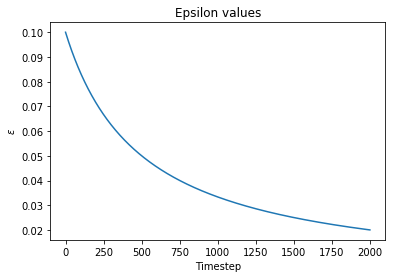

In [11]:
# epsilon 변화 그래프
steps = np.arange(EPISODE)
plt.title('Epsilon values')
plt.xlabel('Timestep')
plt.ylabel('$\\epsilon$')
plt.plot(steps, epsilon_list)

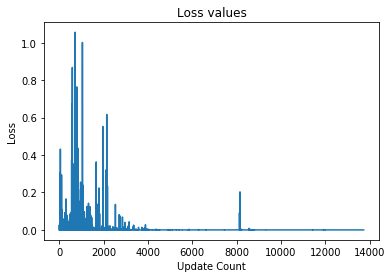

In [12]:
# loss 변화 그래프
update_count = np.arange(update_count)
plt.title('Loss values')
plt.xlabel('Update Count')
plt.ylabel('Loss')
plt.plot(update_count, loss_list)

### Test agent

In [13]:
state = env.reset()
state = np.reshape(state, [1])
done = False
limit = 0

epsilon = 0.0
while not done and limit < 30:
    curr_q = sess.run(q_value, feed_dict={inputs: state})
    action = np.argmax(curr_q)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1])
    env.render()
    state = next_state
    limit += 1

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
